In [13]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# -- import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

# -- Print torch and cuda versions
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)


# -- Generic libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from IPython.display import Image

torch:  1.10 ; cuda:  1.10.2


In [14]:
# -- Variables
data_folder = 'data/img/'
thing_classes=['Person']

In [15]:
def get_thing_dicts(json_path):
    with open(json_path) as f:
        dataset_dicts = json.load(f)
    return dataset_dicts
get_thing_dicts(
    os.path.join(data_folder, 'train', 'train.json')
)

[{'file_name': 'data/img/train/0.png',
  'image_id': 0,
  'height': 360,
  'width': 496,
  'annotations': [{'bbox': [102, 217, 26, 24],
    'bbox_mode': 1,
    'category_id': 0},
   {'bbox': [210, 212, 20, 26], 'bbox_mode': 1, 'category_id': 0}]},
 {'file_name': 'data/img/train/1.png',
  'image_id': 1,
  'height': 360,
  'width': 496,
  'annotations': [{'bbox': [84, 192, 44, 49],
    'bbox_mode': 1,
    'category_id': 0},
   {'bbox': [209, 214, 22, 25], 'bbox_mode': 1, 'category_id': 0}]},
 {'file_name': 'data/img/train/2.png',
  'image_id': 2,
  'height': 360,
  'width': 496,
  'annotations': [{'bbox': [78, 178, 63, 64],
    'bbox_mode': 1,
    'category_id': 0},
   {'bbox': [210, 217, 20, 21], 'bbox_mode': 1, 'category_id': 0}]},
 {'file_name': 'data/img/train/3.png',
  'image_id': 3,
  'height': 360,
  'width': 496,
  'annotations': [{'bbox': [209, 213, 20, 26],
    'bbox_mode': 1,
    'category_id': 0},
   {'bbox': [89, 220, 34, 21], 'bbox_mode': 1, 'category_id': 0}]},
 {'file_nam

In [16]:
# -- Register dataset
for d in ["train", "valid"]:
    DatasetCatalog.register(
        "thing_"+d, 
        lambda d=d: get_thing_dicts(
            os.path.join(data_folder, d, f'{d}.json')
        )
    )
    MetadataCatalog.get("thing_"+d).set(
        thing_classes=thing_classes
    )
thing_metadata = MetadataCatalog.get("thing_train")
thing_metadata

AssertionError: Dataset 'thing_train' is already registered!

In [ ]:
dataset_dicts = get_thing_dicts(data_folder+"train/"+'train.json')
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(
        img[:, :, ::-1], 
        metadata=thing_metadata, 
        scale=1
    )
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [ ]:
# zooed_model = \
#     'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'
zooed_model = \
    'COCO-Detection/retinanet_R_50_FPN_1x.yaml'

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(zooed_model))
cfg.INPUT.MIN_SIZE_TRAIN = (400,)
cfg.DATASETS.TRAIN = ("thing_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(zooed_model)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64#128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
cfg.MODEL.RETINANET.NUM_CLASSES = len(thing_classes)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrectly use num_classes+1 here.

## Inference & evaluation using the trained model

Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:

In [23]:
import os
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .2   # set a custom testing threshold
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = .2
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

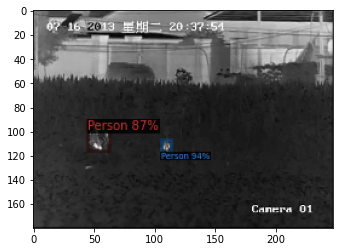

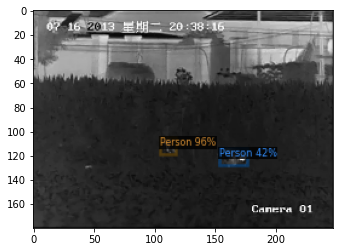

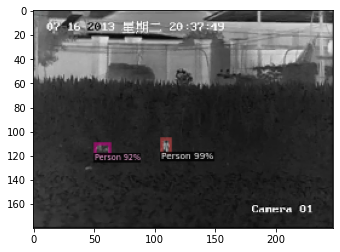

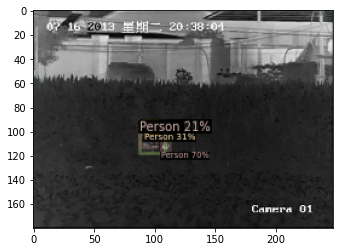

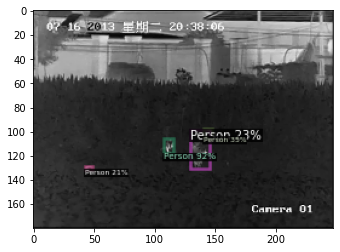

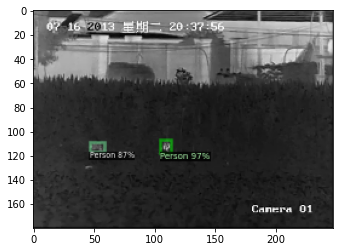

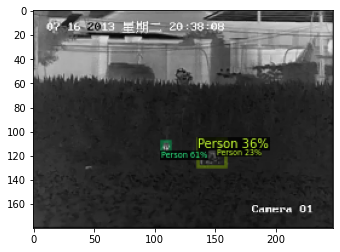

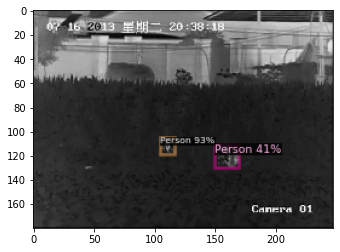

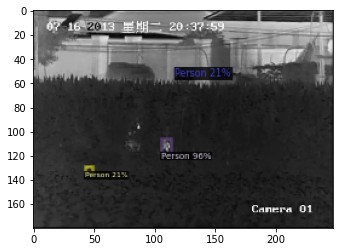

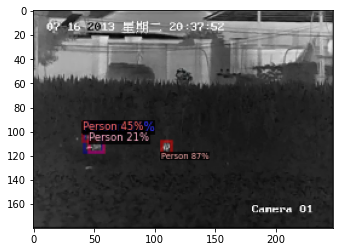

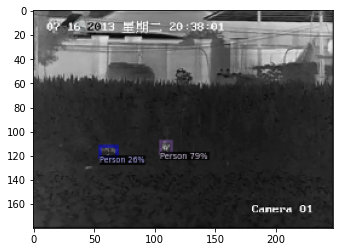

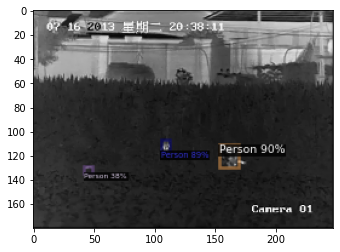

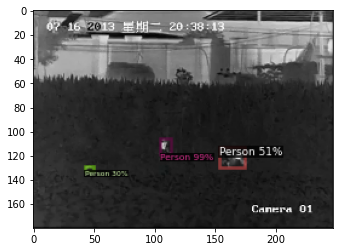

In [24]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_thing_dicts(
    os.path.join(data_folder, 'valid', 'valid.json')
)
for d in random.sample(dataset_dicts, 13):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=thing_metadata, 
                   scale=0.5, 
#                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()